# # Dermatologist-AI

## Introduction

In this mini project, we have to design an algorithm that can visually diagnose [melanoma](http://www.skincancer.org/skin-cancer-information/melanoma), the deadliest form of skin cancer.  In particular, algorithm will distinguish this malignant skin tumor from two types of 

- [Begnign nevus](http://missinglink.ucsf.edu/lm/dermatologyglossary/nevus.html)
- [seborrheic keratoses](https://www.aad.org/public/diseases/bumps-and-growths/seborrheic-keratoses)

The data and objective are pulled from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a).  As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis).  In this project, we will create a model to generate our own predictions.

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import datasets, transforms, models
from collections import OrderedDict
import pandas as pd

import torchvision.models as models

import os
from torchvision import datasets

import glob 
import cv2

## Explore data 

The data was pulled from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a). And there are:
- 2000 images for training 
- 150 images for validation
- 600 images for testing 

Explore the training data and see what kind of images it contains.

15


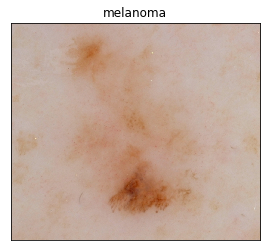

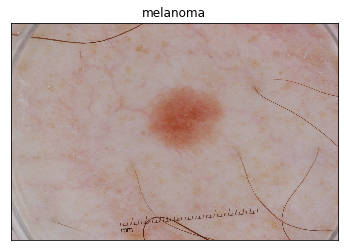

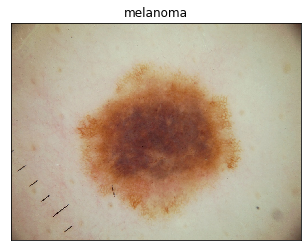

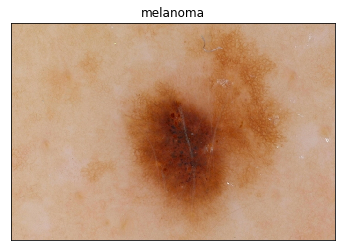

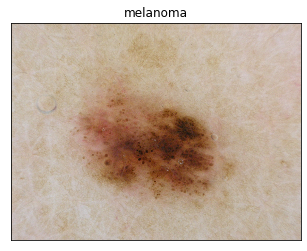

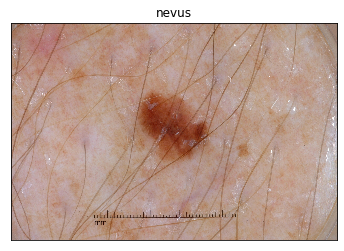

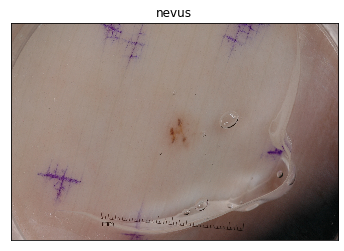

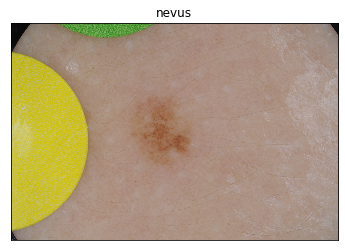

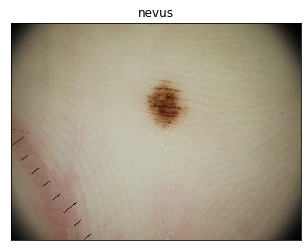

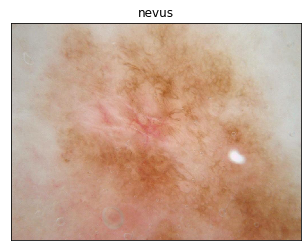

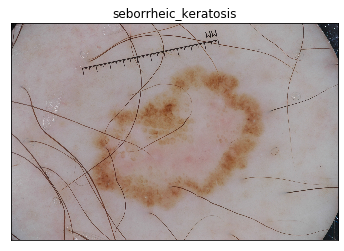

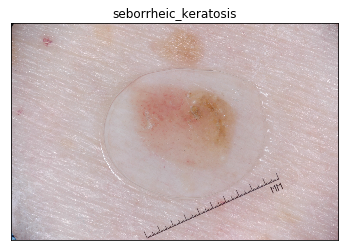

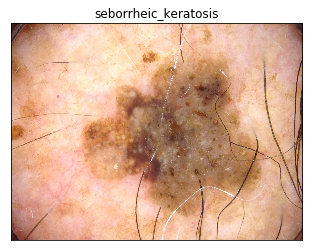

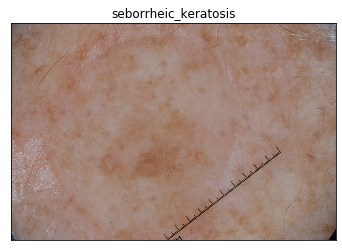

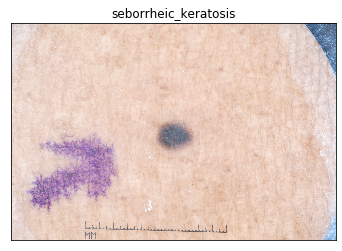

In [15]:


train_dir = ["data/train/melanoma", 
               "data/train/nevus",
               "data/train/seborrheic_keratosis"]

def get_images_paths(directory, n_per_class):
    img_paths = []
    for i in range(3):
        cont = 1
        for file in glob.glob(directory[i]+"/*.jpg"):
            img_paths.append(file)
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
            #print("image: ", directory[i], " has shape: ", image.shape)
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            ax1.set_xticks([])
            ax1.set_yticks([])

            ax1.set_title(directory[i].split("/")[2])
            ax1.imshow(image)
            if cont == n_per_class:
                break
            cont +=1 

         
    return img_paths

# Get a sample of 15 training images (5 for each class)
img_paths = get_images_paths(train_dir, 5)
print(len(img_paths))
#print(img_paths)

In [33]:

## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

train_data = datasets.ImageFolder('data/train',transform=train_transforms)
test_data = datasets.ImageFolder('data/test',transform=test_transforms)
valid_data = datasets.ImageFolder('data/valid',transform=test_transforms)

print('Number of images in training set : ' + str(len(train_data)))
print('Number of images in test set : ' + str(len(test_data)))
print('Number of images in validation set : ' + str(len(valid_data)))


loaders_transfer = {'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True),
                   'test': torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True),
                   'valid': torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)}

Number of images in training set : 2000
Number of images in test set : 600
Number of images in validation set : 150


---
<a id='step4'></a>
## Create a CNN to Classify Cancer (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify cancer from images.  

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify Cancer.  Used vgg16 for transfer learning.

In [92]:
model_transfer = models.vgg19(pretrained=True)
model_transfer



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [93]:

#Lets freeze training for feature layers
for param in model_transfer.classifier.parameters():
    param.requires_grad = False

In [94]:
in_features = model_transfer.classifier[6].in_features
in_features

output_classes = len(train_data.classes)
output_classes

model_transfer.classifier[6] = nn.Linear(in_features, output_classes)
    
model_transfer 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Used CrossEntropyLoss as loss function and SGD as optimizer.

In [95]:
import torch.optim as optim
import numpy as np

criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.01)

#optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [96]:
# train the model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
  
            optimizer.zero_grad()    
            ## find the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
             # print training/validation statistics 
            if (batch_idx+1) % 40 == 0:
                print('Epoch: {} \tBatch: {} \tTraining Loss: {:.6f}'.format(epoch, batch_idx + 1, train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            # print training/validation statistics 
            if (batch_idx+1) % 40 == 0:
                print('Epoch: {} \tBatch: {} \tValidation Loss: {:.6f}'.format(epoch, batch_idx + 1, valid_loss))
           
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
    return model


n_epochs = 3
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Batch: 40 	Training Loss: 0.826325
Epoch: 1 	Batch: 80 	Training Loss: 0.811003
Epoch: 1 	Training Loss: 0.810653 	Validation Loss: 1.066004
Validation loss decreased (inf --> 1.066004).  Saving model ...
Epoch: 2 	Batch: 40 	Training Loss: 0.749770
Epoch: 2 	Batch: 80 	Training Loss: 0.724451
Epoch: 2 	Training Loss: 0.724517 	Validation Loss: 0.869037
Validation loss decreased (1.066004 --> 0.869037).  Saving model ...
Epoch: 3 	Batch: 40 	Training Loss: 0.703278
Epoch: 3 	Batch: 80 	Training Loss: 0.696369
Epoch: 3 	Training Loss: 0.698165 	Validation Loss: 0.799026
Validation loss decreased (0.869037 --> 0.799026).  Saving model ...


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of Cancer images. 

In [97]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

#4 epoch -- 0% - resnet18 Test Accuracy:  0% ( 2/836)
#10 epoch -- 0% - resnet18 Test Accuracy:  0% ( 2/836)
#4 epoch -- 0% - vgg16 Test Accuracy: 80% (676/836)

Test Loss: 0.829166


Test Accuracy: 57% (344/600)


In [99]:
# def check_accuracy_on_test(testloader):    
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         cont = 1
#         for data in testloader:
#             images, labels = data
#             #images, labels = images.to(device), labels.to(device)
#             cont += 1
#             outputs = model_transfer(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return (100*correct/total)

# model_transfer.eval()
# accuracy = check_accuracy_on_test(loaders_transfer['test'])
# print('Accuracy of the network on the 600 test images: %d %%' % accuracy)

In [100]:
from PIL import Image

def get_predictions(img_paths):

    image = Image.open(img_paths)
    image = test_transforms(image)
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    prediction = model_transfer(image)

    return prediction

In [101]:
df = pd.read_csv("ground_truth.csv")

rank1 = [] #melanoma
rank2 = [] #benign
Id = []

for i,row in df.iterrows():
    prediction = get_predictions(row['Id'])
    rank1.append(float(prediction.data[0][0]))
    rank2.append(float(prediction.data[0][2]))
    Id.append(row['Id'])

    
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [102]:
sample_predictions = pd.DataFrame()

sample_predictions['Id'] = Id
sample_predictions['task_1'] = rank1
sample_predictions['task_2'] = rank2

sample_predictions.to_csv("sample_predictions.csv")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


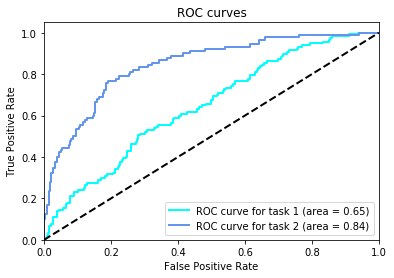

Category 1 Score: 0.645
Category 2 Score: 0.845
Category 3 Score: 0.745


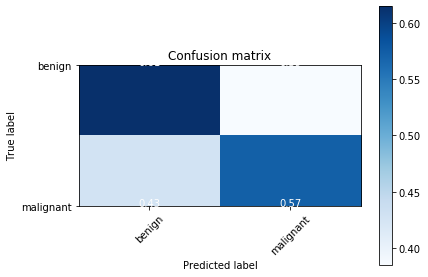

In [103]:
import pandas as pd
import sys
import itertools
import get_results as results

threshold = 0.5

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv('sample_predictions.csv')
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
results.plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)

#### Future work

More fine tuning with different pretrained models